Tutorial followed: https://www.youtube.com/watch?v=kSqxn6zGE0c

### Prerequisites
1. Check Python installation version (idk which one works, i use 3.11 during coding :p)

2. Install required packages via terminal: ```pip install -r requirements.txt```

In [20]:
# Image Preparation Imports
import cv2
import pandas as pd 
import numpy as np
import datetime
import matplotlib.pyplot as plt
from glob import glob
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

file_name = '../data/wiki.mat'

def matlab_datenum_to_date(matlab_dn):
    return datetime.date.fromordinal(int(matlab_dn) - 366)

def compute_wiki_age(photo_year, birth_datenum):
    photo_date = datetime.date(photo_year, 7, 1)
    birth_date = matlab_datenum_to_date(birth_datenum)
    delta = photo_date - birth_date
    return delta.days / 365.2425


def process_matfile(file_name):
    # Load the data
    data = loadmat(file_name)['wiki'][0, 0]
    data_dict = {key: data[key] for key in data.dtype.names}

    # Convert data into filename-based dictionary
    filename_dict = {}

    for i in range(len(data_dict['full_path'][0])):
        # Remove invalid faces
        if np.isinf(data_dict['face_score'][0][i]) or not np.isnan(data_dict['second_face_score'][0][i]):
            continue

        filename = data_dict['full_path'][0][i][0]
#         filename_dict[filename] = {
#             # 'dob': data_dict['dob'][0][i],
#             # 'photo_taken': data_dict['photo_taken'][0][i],
#             # 'gender': data_dict['gender'][0][i],
#             # 'name': data_dict['name'][0][i],
#             # 'face_location': data_dict['face_location'][0][i],
#             # 'face_score': data_dict['face_score'][0][i],
#             # 'second_face_score': data_dict['second_face_score'][0][i],
#             'approx_age': compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])
#         }
        filename_dict[filename] = compute_wiki_age(data_dict['photo_taken'][0][i], data_dict['dob'][0][i])

    return filename_dict

# Load filenames anda ssociated data
data = process_matfile(file_name)


In [21]:
#some data cleaning to get rid of excessively large or negative values in the predicted age category
print(len(data))
mean_val = sum(data.values()) / len(data)
print(mean_val)
for key in list(data.keys()):
    if data[key] > 100 or data[key] < 1:
        del data[key]
print(len(data))
print(min(data.values()), max(data.values()))

40216
38.60996556567274
40147
1.3525260614523227 99.87337180092678


In [22]:
# Load in images
images = []
for i in data.keys():  
    img = cv2.imread('../data/wiki_crop/'+i)
    images.append(img)

print(f"Number of images loaded: {len(images)}")

Number of images loaded: 40147


In [23]:
#create classification for y variable (can make more categories, just put this in for now)
classifications = []
for key in data.keys():
    if data[key] > mean_val:
        classifications.append('older')
    else:
        classifications.append('younger')

## *Resizing Examples* ##

In [24]:
#resizing images examples
im2 = cv2.resize(images[2], (200,200), interpolation=cv2.INTER_LINEAR)
im0 = cv2.resize(images[0], (200,200), interpolation=cv2.INTER_LINEAR)

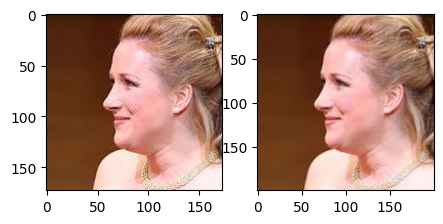

In [25]:
# scaled up to 200x200
plt.figure(figsize=[5,5])
plt.subplot(121);plt.imshow(images[2][:,:,::-1])
plt.subplot(122);plt.imshow(im2[:,:,::-1])

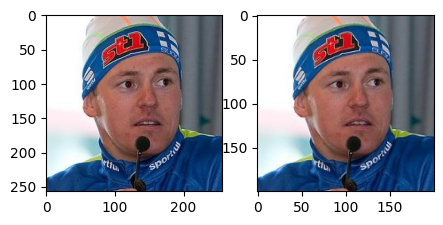

In [26]:
# scaled down to 200x200
plt.figure(figsize=[5,5])
plt.subplot(121);plt.imshow(images[0][:,:,::-1])
plt.subplot(122);plt.imshow(im0[:,:,::-1])

## end of examples ##

In [27]:
#resize all images (can change width and height to what we find to be best)
new_images = []
width = 200
height = 200
for image in images:
    new_im = cv2.resize(image, (width,height), interpolation=cv2.INTER_LINEAR)
    new_images.append(new_im)

In [28]:
# split in to train and test sets
x_train, x_test, y_train, y_test = train_test_split(new_images, classifications, test_size = 0.8, random_state = 1)

In [29]:
//wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww
def label_to_int(label):
    return 1 if label == 'older' else 0

X_train = np.array(x_train, dtype='float32')
X_test  = np.array(x_test, dtype='float32')

y_train_int = np.array([label_to_int(lbl) for lbl in y_train], dtype='int32')
y_test_int  = np.array([label_to_int(lbl) for lbl in y_test], dtype='int32')

#pixel values from 0-255 -> 0-1
X_train /= 255.0
X_test  /= 255.0

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_int.shape)

X_train shape: (8029, 200, 200, 3)
y_train shape: (8029,)


In [30]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(height, width, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')  #younger=0, older=1
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\Sasha\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
#Initial exp
history = model.fit(
    X_train, y_train_int,
    validation_split=0.1,  # 10% of training as validation
    epochs=5,
    batch_size=32,
    verbose=1
)

test_loss, test_acc = model.evaluate(X_test, y_test_int, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

predictions = model.predict(X_test[:5])
pred_classes = np.argmax(predictions, axis=1)

print("Sample Predictions:")
for i in range(5):
    label_str = 'older' if pred_classes[i] == 1 else 'younger'
    true_str = 'older' if y_test_int[i] == 1 else 'younger'
    print(f"Predicted: {label_str}, Actual: {true_str}")


Epoch 1/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 45s 172ms/step - accuracy: 0.5954 - loss: 1.3139 - val_accuracy: 0.6700 - val_loss: 0.6145
Epoch 2/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step - accuracy: 0.7130 - loss: 0.5605 - val_accuracy: 0.6849 - val_loss: 0.5970
Epoch 3/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.7888 - loss: 0.4529 - val_accuracy: 0.6899 - val_loss: 0.5974
Epoch 4/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.8469 - loss: 0.3570 - val_accuracy: 0.6675 - val_loss: 0.6819
Epoch 5/5
226/226 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.9056 - loss: 0.2316 - val_accuracy: 0.6849 - val_loss: 0.9060
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.6775 - loss: 0.9289
Test Loss: 0.9459, Test Accuracy: 0.6769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Sample Predictions:
Predicted: younger, Actual: younger
Predicted: younger, Actual: younger
Predicted: younger, Actual: younger
Predicted: younger, Actual: younger
Predicted: older, Actual: y

In [ ]:
# Reading in images
glob()


In [ ]:

img_mpl = plt.imread()

img_cv2 = cv2.imread()




In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(img_mpl)
